# kernel для соревнования Raiffeisen Data Cup
это не в точности тот kernel который я использовал на самом соревновании(11 место на Private Liderboard), так как оригинальный был бездарно потерян. при его использовании результат будет немного получше, но я  все же не стал использовать Open Street Map(хотелось восстановить оригинальное решение, а не серьезно его улучшить используя внешние источники)
про который банально не знал на момент соревнования , так что результаты если и будут отличаться, то незначительно

ссылка на страницу соревнования : https://boosters.pro/champ_11


Задача заключается предсказания места проживания и работы по истории транзакций клиента
### какие признаки даны 

* terminal_id идентификационный номер терминала
* customer_id идентификационный номер клиента
* amount количество потраченных средств за транзакцию
* country страна
* currency валюта
* mcc код категории продавца
* transaction_date дата транзакции
* atm_address адрес банкомата
* pos_address адрес установки pos-терминала
* pos_address_lat адрес установки pos-терминала широта
* pos_address_lon адрес установки pos-терминала долгота
* work_add_lat широта работы клиента
* work_add_lon долгота работы клиента
* home_add_lat широта дома клиента
* home_add_lon долгота дома клиента

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import pyprind
import io
import time
import json
import requests
import sklearn

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 999

In [4]:
train_data = pd.read_csv( 'train_set.csv', parse_dates=['transaction_date'], low_memory=False )
test_data = pd.read_csv('test_set.csv',parse_dates=['transaction_date'] , low_memory=False)
test_data.rename(  columns={ 'pos_address_lat':'pos_adress_lat', 'pos_address_lon':'pos_adress_lon'  }, inplace=True )

In [6]:
#очищает и удаляет мсс-коды которые есть только в train или test
def clear_mcc(df_train,df_test):
    df_test['mcc'] = df_test['mcc'].apply( lambda x : int(x.replace(',',''))  if type(x) is not type(0) else x )
    #delete row with invalid mcc code
    clear_mcc_bad_code( df_train )
    clear_mcc_bad_code(df_test)
    mcc_set_train = set(df_train.mcc.unique())
    mcc_set_test = set(df_test.mcc.unique())
    clear_mcc_code(df_test,mcc_set_test.difference(mcc_set_train))
    clear_mcc_code(df_train, mcc_set_train.difference(mcc_set_test))

def clear_mcc_code( df , clear_list):
    index = []
    cashed = df.mcc 
    for mcc in clear_list:
        sampled = df[cashed==mcc]
        if len(sampled)>0:
            index+=sampled.index.tolist()
    if len(index)>0:
        df.drop(labels = index,inplace=True,axis=0)

def clear_mcc_bad_code( df  ):
    code = df.mcc.unique()
    bad_code = [ mcc for mcc in code if mcc not in mcc_info.index ]
    clear_mcc_code(df, bad_code)

def clear_mcc(df_train,df_test):
    df_test['mcc'] = df_test['mcc'].apply( lambda x : int(x.replace(',',''))  if type(x) is not int else x )
    #удаление невалидных кодов
    clear_mcc_bad_code( df_train )
    clear_mcc_bad_code(df_test)
    
    mcc_set_train = set(df_train.mcc.unique())
    mcc_set_test = set(df_test.mcc.unique())
    #удаление кодов которые встречаются тольк в train или только test
    clear_mcc_code(df_test,mcc_set_test.difference(mcc_set_train))
    clear_mcc_code(df_train, mcc_set_train.difference(mcc_set_test))
    
#простейшее преобразование , уменьшающее количество уникальных кодов, кластеризует коды в группы по количеству
def create_mcc_dict(train_df , test_df, n_clusters):
    mcc_value = train_df.mcc.value_counts() + test_df.mcc.value_counts()
    return pd.Series( 
        AgglomerativeClustering(n_clusters=n_clusters).fit_predict(mcc_value.values.reshape(-1,1)) ,
        index = mcc_value.index ) 
    

In [ ]:
#файл с mcc-кодами, взять с https://github.com/greggles/mcc-codes
mcc_info = pd.read_csv('mcc_codes.csv',index_col='mcc')
удалим те mcc коды которых нет в train и test одновременно
clear_mcc(train_data,test_data)

mcc - Merchant Category Code это имеющаяся в данных категориальная переменная, 

In [19]:
mcc_vals = train_data.mcc.map(mcc_info['edited_description']).value_counts()

Отобразим количество транзакций по каждому mcc

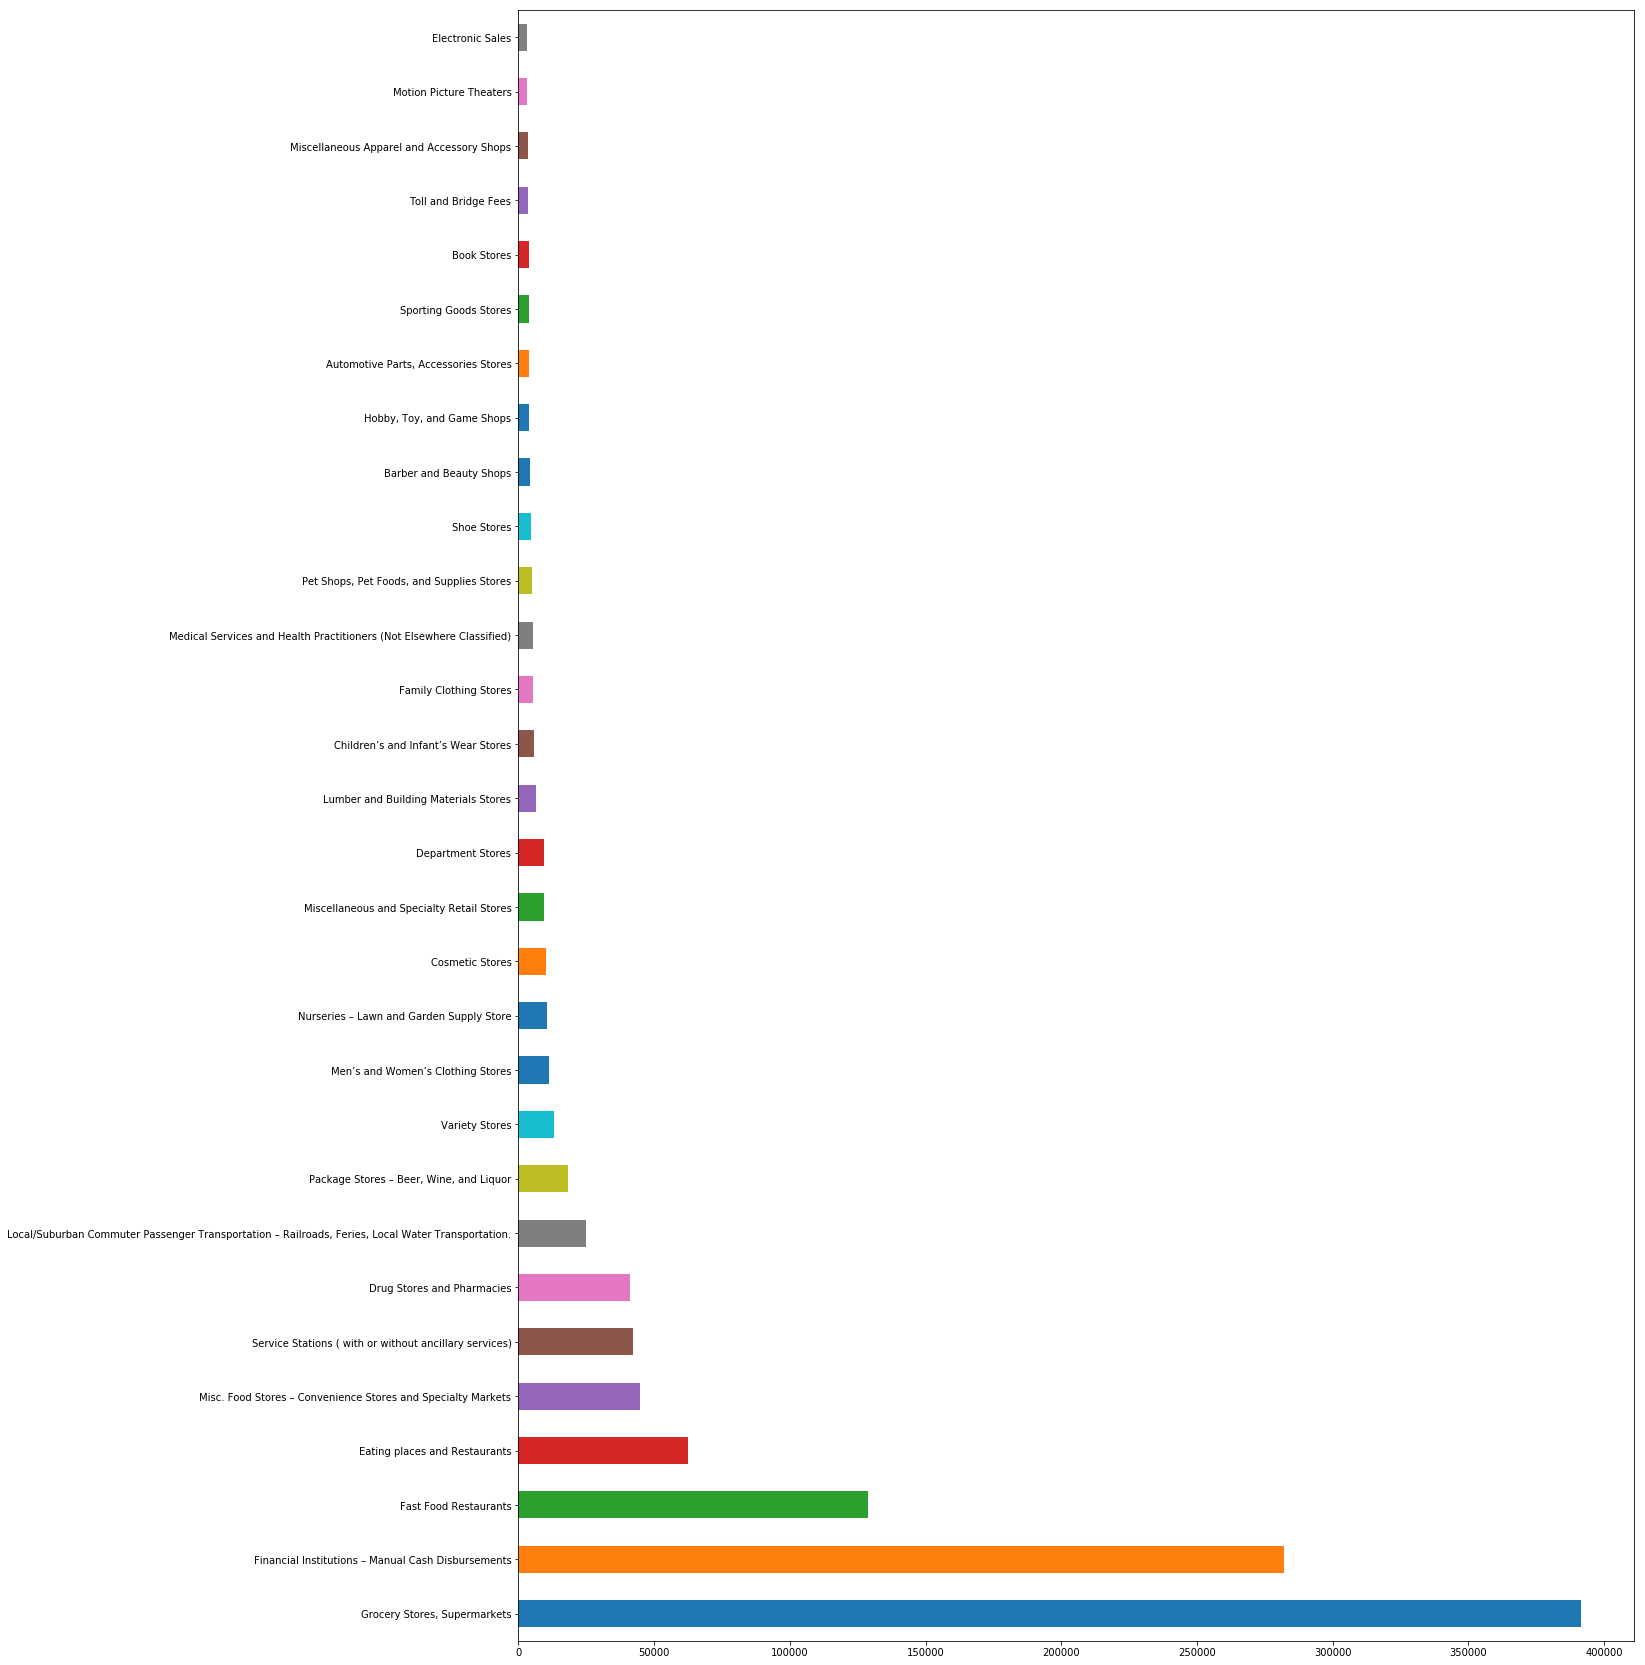

In [66]:
mcc_vals[:30].plot(kind = 'barh',figsize=(20,30))

Как видно , большая часть транзакций распределенна относительно в небольшом числее групп, для обработки этой информации мы постром одномерную кластеризацию над количеством MCC кодов. Вообще такое преобразование не очень хорошая идея, но на самом чемпионате я сделал именно так

In [23]:
mcc_clusters_count = 10
mcc_dictionary = create_mcc_dict(train_data,test_data,mcc_clusters_count)
train_data['mcc'] = train_data.mcc.map(mcc_dictionary)
test_data['mcc'] = test_data.mcc.map(mcc_dictionary)

In [25]:
#удаляет транзакции без геоданных
def clear_atm_pos_data(df):
     return df[ ( ( ~(df.atm_address_lat.isnull()) & ~(df.atm_address_lon.isnull()) ) | 
               ( ~(df.pos_adress_lat.isnull()) & ~(df.pos_adress_lon.isnull()) ) ) ][ ~(~(df.atm_address_lat.isnull()) & ~(df.pos_adress_lat.isnull())) ] 
    
#сливает разные коодинатные столбцы в один
def union_pos_atm_data(df):
    atm_df = df[~df.atm_address_lat.isnull()][['atm_address_lat','atm_address_lon']]
    pos_df = df[~df.pos_adress_lat.isnull()][['pos_adress_lat','pos_adress_lon']]
    atm_df = atm_df.rename(columns={'atm_address_lat':'lat','atm_address_lon':'lon'})
    pos_df = pos_df.rename(columns={'pos_adress_lat':'lat','pos_adress_lon':'lon'})
    return pd.concat( ( df, pd.concat( (atm_df,pos_df) ,axis=0)),axis = 1, )    



 поля c адресами терминалов сильно зашумленны, поэтому я не пытался достать оттуда информацию, а просто их грохнул. 
 и валюты тоже грохнул, транзакция не в рублях было ~0.2%.
 поле города тоже не очень информативно - много уникальных значений, для одной только Москвы будет с 30-40 синонимов там
 и да, это поле я тоже грохнул. а поле страны просто неинформативно, поэтому я грохнул и его
 также часть транзакций не содержит вообще координаты pos и atm терминала, вообще я пытался найти координаты для таких случаев по коду терминала, но для всех транзакций для которых не было координат, все совпадения по коду терминала были неуникальны, то есть с одним и тем же кодом терминала были транзакции с различными(порой даже в разных городах) координатами

In [26]:
train_data = clear_atm_pos_data(train_data)
test_data = clear_atm_pos_data(test_data)
train_data = union_pos_atm_data(train_data)
test_data = union_pos_atm_data(test_data)
common_drop_list = [ 'atm_address','atm_address_lat','atm_address_lon'  , 'pos_address',
                   'pos_adress_lat','pos_adress_lon' ,'country', 'city' ,'currency']  
train_data.drop(axis=1,labels=common_drop_list,inplace=True)
test_data.drop(axis=1,labels=common_drop_list,inplace=True)

C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [27]:
def encode_data(train,test,columns):
    encoder_dict={}
    for col in columns:
        uniq_vals= train[col].unique().tolist() + test[col].unique().tolist()
        val_encoder = LabelEncoder().fit(uniq_vals)
        train[col] = val_encoder.transform(train[col])
        test[col] = val_encoder.transform(test[col])
        encoder_dict[col] = val_encoder
    return encoder_dict

#для сабмита потом пригодиться сам encoder
encoder_dict = encode_data( train_data,test_data,['customer_id','terminal_id'] )

сливаем train и test в одну таблицу, в дальнейшем будет работать только с ними

In [30]:
common_data = pd.concat( (train_data,test_data), axis=0, ignore_index=True )

In [49]:
from scipy.spatial.distance import cdist, pdist
import folium

для примера зашумленности кода терминала найду и отрисую какой-нибудь зашумленный teminal_id

In [58]:
groups = common_data.groupby(by = 'terminal_id')
vals_matrix = common_data[['lat','lon']].values
finded_id = None
max_uniq_place = 0
for term_id,index in groups.groups.items():
    coord = vals_matrix[index]
    res = np.sum(cdist(coord,coord)[0,:]>0.02)
    if res > max_uniq_place:
        max_uniq_place = res
        finded_id = term_id

In [60]:
finded_coord = coord_data.query('terminal_id=={}'.format(finded_id))[['lat','lon','transaction_date']].drop_duplicates()
fmap = folium.Map([55,45])
for _ ,row in finded_coord.iterrows():
    folium.CircleMarker([row['lat'],row['lon']],radius = 10).add_to(fmap)
fmap

нужно найти далекие коды терминалов, сделать для них новые метки

In [67]:
vals = common_data[[ 'terminal_id','lat','lon', ]]
vals_pure = vals[['lat','lon']].values
new_id = vals.terminal_id.max()+1
groups = vals.groupby(by = 'terminal_id').groups
bar = pyprind.ProgBar(iterations=len(groups))
new_code = np.zeros(len(vals))
new_center = np.zeros((len(vals),2))
for term_id,index in groups.items():
    coord = vals_pure[index]
    tree = NearestNeighbors().fit(coord)
    request = tree.radius_neighbors(coord, 0.001, return_distance=False)
    if len(request[0])!=len(coord) :
        handled_index = set()
        for row in request:
            row_set = set(row)
            intersection = handled_index.intersection(row_set)
            if intersection==row_set:
                continue
            update_list = list(row_set.difference(handled_index)) if len(intersection)>0 else row 
            handled_index = handled_index.union(update_list)
            new_code[index[update_list]] = new_id
            new_id+=1
            new_center[index[update_list]] = np.mean( coord[update_list],axis=0 )
    else:
        new_code[index] = term_id
        new_center[index] = coord[0,:]
    bar.update()
    
common_data[['lat','lon']] = new_center
common_data['terminal_id'] = new_code

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:47


для каждой транзакции сделаем OneHotEncode преобразования дней недели и выделенного mcc кластера

In [68]:
#извлечем dummy-переменные для дней недели и месяцев
common_data['week_day'] =  common_data['transaction_date'].map(lambda  x : x.weekday() )
common_data = pd.get_dummies( common_data,columns=['mcc','week_day'] )


Так же для всех терминалов найдем ближайшую к ним станцию метро и город, добавим расстояние до них в качестве признаков

In [71]:
#найденный где-то на просторах интернетов файл со координатами городов
city_coord = pd.read_csv( 'big_city.csv',  delimiter='\t' )

#вытащим через api headhunter координаты всех станций метро
res = requests.get('https://api.hh.ru/metro/',proxies = proxies )
result  = res.json()
metro_index = ['lat','lon','name','city_name','city_id']
metro_df = pd.DataFrame( columns = metro_index )
for city in result:
    city_id = city['id']
    city_name = city['name']
    for line in city['lines']:
        stations = line['stations']
        for station in stations:
            lat = station['lat']
            lon = station['lng']
            name = station['name']
            metro_df = metro_df.append( pd.Series([lat,lon,name,city_name,city_id],index=metro_index),ignore_index=True )

metro_coord = metro_df[['lat','lon']].values


In [ ]:
tree_metro = NearestNeighbors().fit(city_coord[['lat','lon']].values)
tree_city = NearestNeighbors().fit(metro_df[['lat','lon']].values) 

groups = common_data.groupby(by='terminal_id')

dist_name = ['metro_id','city_id','metro_dist','city_dist','lat','lon']
dist_fea = {}

coords = common_data[['lat','lon']].values
bar = pyprind.ProgBar(iterations=len(groups.groups))
for terminal_id,index in groups.groups.items():
    coord = coords[index[0],:].reshape(1,-1)
    metro_request = tree_metro.kneighbors(coord,1)
    city_request = tree_city.kneighbors(coord,1)
    dist_fea[terminal_id] =[ metro_request[1][0][0],
                            city_request[1][0][0],
                            metro_request[0][0][0],
                            city_request[0][0][0],
                            coord[0,0],coord[0,1]]
    bar.update()
    
terminal_dist_fea = pd.DataFrame( dist_fea ).transpose()
terminal_dist_fea.columns = dist_name


In [74]:
terminal_dist_fea.head()

,metro_id,city_id,metro_dist,city_dist,lat,lon
0.0,84.0,90.0,0.029210,1.817155,55.164859,61.431219
1.0,25.0,183.0,0.033676,0.107484,55.915054,37.820812
2.0,41.0,159.0,0.176373,0.009085,55.598411,37.538107
3.0,34.0,91.0,0.079117,5.208196,45.101813,38.983776
4.0,41.0,122.0,0.025888,0.000910,55.770638,37.596566


In [75]:
weekday_name = [ fea for fea in common_data if re.match('week',fea) ]
mcc_name = [fea for fea in common_data if re.match('mcc',fea)]

для каждого customer_id соберем следующую информацию :
* общую сумму по всем транзакциям
* сумму по транзакция по разным mcc кластерам и дням недели
* количесто транзакций по разным mcc кластерам и дням недели
* дельту мемжду первой и последней транзакции в днях
* минимальную и максимальную дату
* количестов дней в которых были транзакции

In [76]:
#аргрегируем общую инфу по юзерам
groups = common_data.groupby(by = 'customer_id')

week_sum = groups[weekday_name].sum(axis=0)
#week_sum.columns = [ 'sum_'+fea for fea in weekday_name ]
mcc_sum = groups[mcc_name].sum(axis=0)
#mcc_sum.columns = [ 'sum_'+fea for fea in mcc_name ]
count_transaction = groups.size()
count_transaction.name = 'count_transaction'
count_days = groups['transaction_date'].nunique()
count_days.name = 'count_days'
time_period = groups['transaction_date'].aggregate(['max','min'])
time_period.columns  = ['date_max','date_min']
amount_total = groups['amount'].sum()
amount_total.name = 'amount_total'

amount = common_data.amount
#amount info нужен не только для агрегации данных по пользователям
amount_info = common_data[weekday_name+mcc_name].apply(lambda x :  x*amount, axis=0 )
amount_info.columns = [ 'amount_' +fea for fea in amount_info.columns ]
amount_info['customer_id'] = common_data.customer_id
amount_group = amount_info.groupby(by = 'customer_id')
amount_partitional = amount_group.sum(axis=0)

user_features = pd.concat( (  count_transaction, count_days ,amount_total , 
                            time_period,mcc_sum ,week_sum, amount_partitional ),axis=1  ) 

добавим к таблице транзакций еще ифнормацию о суммах

In [77]:
amount_info.drop(labels='customer_id',axis=1,inplace=True)
all_data = pd.concat( (common_data,amount_info) ,axis=1)

In [78]:
amount_weekday_name = [ fea for fea in amount_info if re.match('amount_week',fea) ]
amount_mcc_name = [ fea for fea in amount_info if re.match('amount_mcc',fea) ]

здесь собираем финальные данные,причем не просто на каждую пару (customer_id,terminal_id), но и на ее 0.02 окрестность 
###### итоговые признаки:
* partitional-признаки по каждому mcc кластеру и дню недели, к примеру отношение всех транзакций за вторник к общему количеству транзакций пользователя , отношение суммы переводов по первому mcc кластеру ко всей сумме
* разница в днях между первой и последней транзакцией за все места и на это terminal_id
* отношение суммы termina_шв к сумме всех транзакций
* количество транзакций в terminal_id
* отношение количества транзакций в termina_id к общему количеству транзакций
* количесто дней
* отношение количества дней в teminal_id к общему количеству дней
* отношение временного промежутка в terminal_id к общему времени
* средняя сумма за день
* средняя сумма за транзакцию
* отношение среднего к общей сумме транзакций
* расстояние до метро
* расстояние до центра ближайшего города

In [79]:
target_name = ['customer_id','terminal_id' ,'is_home', 'is_work', 'train','test','lat','lon' ]

feature_name = ['amount','mean_amount_part','amount_part','delta_from_firts','delta_from_last','day_count',
                'part_day_count','transaction_count','part_transaction_count','time_part','amount_per_day', 
                'amount_per_transaction','dist_to_city','dist_to_metro','city_id',
                'metro_id'] + mcc_name + weekday_name +amount_weekday_name+amount_mcc_name +target_name

groups = all_data.groupby(by=['customer_id'])
groups_dict = groups.groups

coord_matrix = all_data[['lat','lon']].values
user_info_matrix = user_features.values
all_data_matrix = all_data.values
#val_matrix = np.zeros( (len(groups_dict),len(feature_name))  )

size = len(all_data.groupby(by=['customer_id','terminal_id']))

bar = pyprind.ProgBar( iterations=size )

train_id = set(train_data.customer_id.unique())

partitional_feature_count =  len(all_data.columns[10:])
begin_partional_in_user_matrix = 5
begin_partional_in_all_data_matrix = 10

val_list = []
for i,(customer_id,index) in enumerate(groups_dict.items()):
    
    loc_data = all_data_matrix[index]
    coords = coord_matrix[index]
    terminal_ids = np.unique(loc_data[:,6] )
    tree = NearestNeighbors().fit(coords)
    common_user_info = user_info_matrix[customer_id]
    #Здесь будет грязный код с обращениями по индексам, который мешает читаемсости и понимаемости, но в противном случае этот 
    #кусок кода выполнялся бы ~2.5 часа
    for term_id in terminal_ids:
        term_data = terminal_dist_fea.loc[term_id]
        coord = term_data[['lat','lon']].values
        request = tree.radius_neighbors(coord.reshape(1,-1),0.02,return_distance=False)
        df = loc_data[request[0]]
        part_fea= np.sum(df[:,begin_partional_in_all_data_matrix:],axis=0).astype(np.float64) / common_user_info[begin_partional_in_user_matrix:].astype(np.float64)
        
        delta_from_firts = (common_user_info[4] -  df[:,7].min() ).days
        delta_from_last =  ( common_user_info[3] - df[:,7].max() ).days
        day_count = len(np.unique(df[:,7]))
        part_day_count = day_count / common_user_info[1]
        transaction_count = len(df)
        part_transaction_count = transaction_count / common_user_info[0]
        if common_user_info[3] == common_user_info[4]:
            time_part = 0
        else :
            time_part =  (df[:,7].max()-df[:,7].min()).days  /  (common_user_info[3] -  common_user_info[4] ).days  
        amount =  df[:,0].sum() 
        amount_per_day = amount/ day_count
        amount_per_transaction = amount / transaction_count
        amount_part = amount /  common_user_info[2]
        mean_amount_part = df[:,0].mean() / common_user_info[2]
        
        center = df[:,4:6].mean(axis=0)
        is_home = np.linalg.norm(center-df[0,2:4])<0.02
        is_work = np.linalg.norm(center-df[0,8:10])<0.02
        train = customer_id in train_id
        test = not train
        features=   np.array([ amount ,
                                    amount_part,
                                    mean_amount_part ,
                                    delta_from_firts,
                                    delta_from_last,
                                    day_count,
                                    part_day_count,
                                    transaction_count,
                                    part_transaction_count ,
                                    time_part,amount_per_day, 
                                    amount_per_transaction,
                                    term_data['city_dist'],
                                    term_data['metro_dist'],
                                    term_data['city_id'],
                                    term_data['metro_id']
                                    ] +part_fea.tolist()+[customer_id,term_id,is_home,is_work,train,test] + center.tolist() )
        val_list.append(features)
        
        bar.update()
        

C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:15:32


In [80]:
frame = pd.DataFrame(val_list,columns=feature_name)
fea_for_learn = [ fea for fea in frame if fea not in ['city_id','metro_id','user_id','customer_id','is_home','is_work','train','test']]
frame['coord_norm'] = frame[['lat','lon']].apply( lambda x : np.linalg.norm(x) , axis=1 )
frame.fillna(0,inplace=True)

разбивать на тренировочные данны и валидацию будем так, чтобы customer был бы либо в train, либо в test

In [81]:
train_set = frame.query('train==True')
test_set = frame.query('test==True')
user_id = frame.customer_id.unique()
train_id,test_id = train_test_split(user_id) 
train_df = train_set[train_set['customer_id'].map( lambda  x :  x in train_id )]
test_df = train_set[train_set['customer_id'].map(lambda x : x in test_id)]

In [82]:
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm
from lightgbm import LGBMClassifier

на одних и тех же данных постром 2 модели 

In [85]:
model_home = LGBMClassifier( n_estimators=500, max_depth=15,learning_rate=0.01 ,class_weight='balanced' )
model_home.fit( train_df[fea_for_learn], train_df['is_home'],verbose=False,
               eval_set=[(test_df[fea_for_learn],test_df['is_home'])] )
print( 'train score :',roc_auc_score( y_score=  model_home.predict_proba(train_df[fea_for_learn])[:,1],y_true = train_df['is_home'] ) ) 
print( 'test score :',roc_auc_score( y_score=  model_home.predict_proba(test_df[fea_for_learn])[:,1],y_true = test_df['is_home'] ) )  
print(classification_report(y_pred=model_home.predict(train_df[fea_for_learn]),y_true = train_df['is_home']  ))
print( classification_report(y_pred=model_home.predict(test_df[fea_for_learn]),y_true=test_df['is_home']) )

train score : 0.9156858751477929
test score : 0.8743902650565085


C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

        0.0       0.96      0.80      0.87    350698
        1.0       0.54      0.87      0.67     96875

avg / total       0.87      0.81      0.83    447573

             precision    recall  f1-score   support

        0.0       0.94      0.78      0.85    120853
        1.0       0.50      0.83      0.63     32774

avg / total       0.85      0.79      0.80    153627



C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [87]:
model_work = LGBMClassifier(n_estimators=500, max_depth=15,learning_rate=0.01 ,class_weight='balanced'  )
model_work.fit( train_df[fea_for_learn], train_df['is_work'],verbose = False,
               eval_set=( test_df[fea_for_learn],test_df['is_work']  ) )
print( 'train score :',roc_auc_score( y_score=  model_work.predict_proba(train_df[fea_for_learn])[:,1],y_true = train_df['is_work'] ) ) 
print( 'test score :',roc_auc_score( y_score=  model_work.predict_proba(test_df[fea_for_learn])[:,1],y_true = test_df['is_work'] ) )  
print(classification_report(y_pred=model_work.predict(train_df[fea_for_learn]),y_true = train_df['is_work']  ))
print( classification_report(y_pred=model_work.predict(test_df[fea_for_learn]),y_true=test_df['is_work']) )

train score : 0.9220082103789132
test score : 0.8377090949455581


C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

        0.0       0.98      0.83      0.90    408327
        1.0       0.33      0.87      0.47     39246

avg / total       0.93      0.83      0.86    447573

             precision    recall  f1-score   support

        0.0       0.97      0.81      0.88    141048
        1.0       0.25      0.70      0.36     12579

avg / total       0.91      0.80      0.84    153627



C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


важности фич для обоих моделей совпадаю , поэтому отрисую только для одной

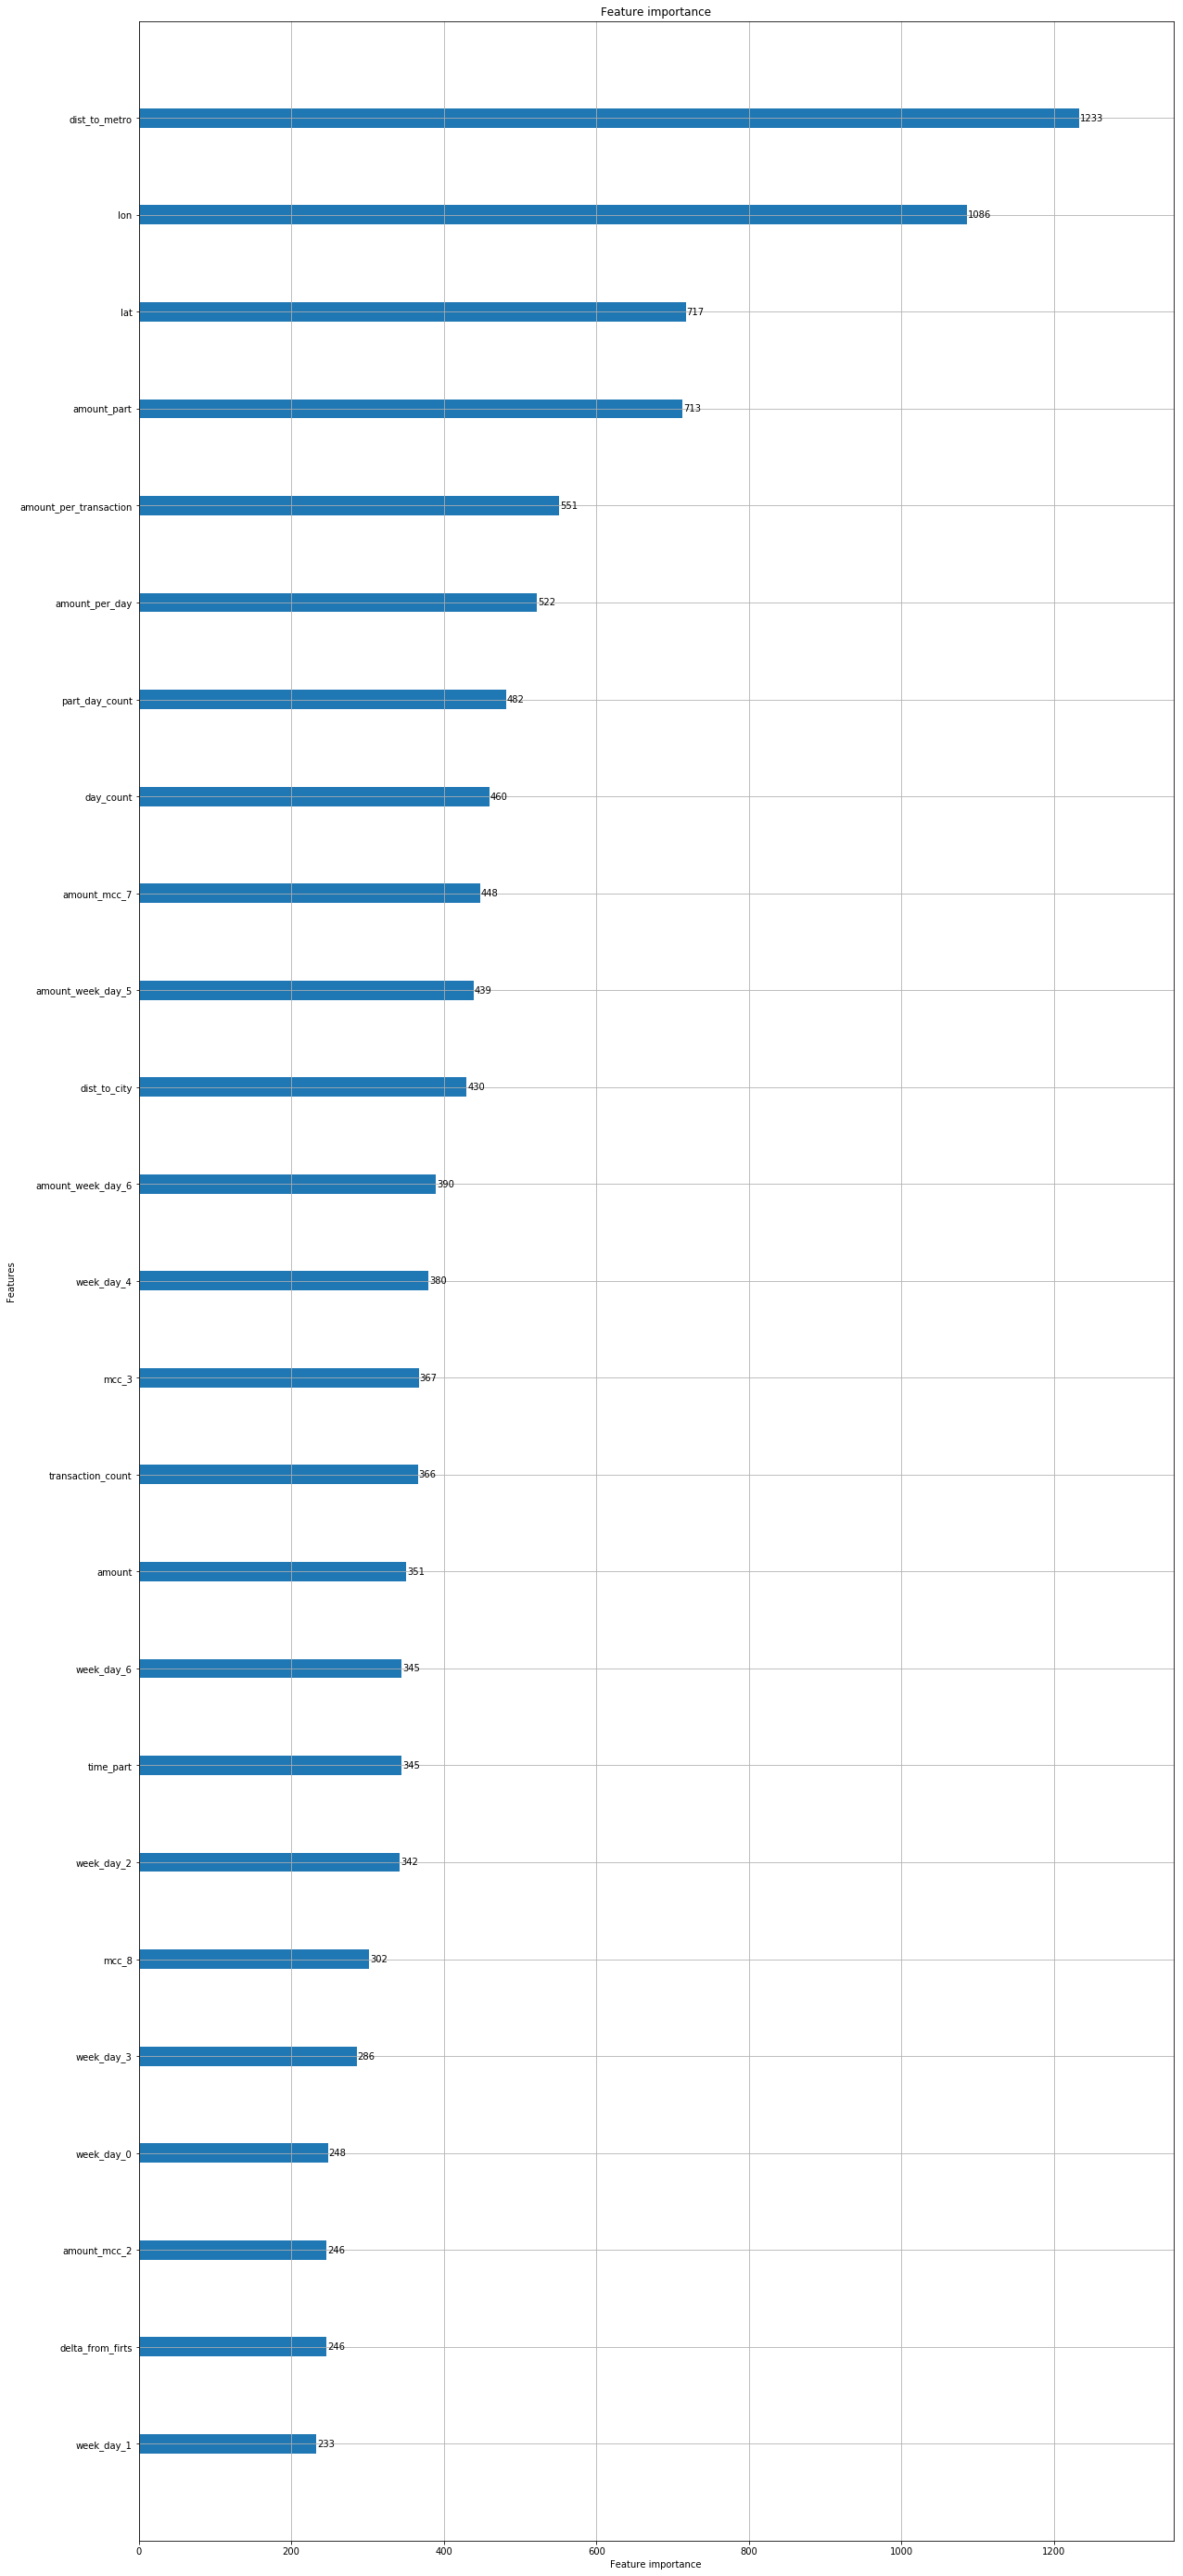

In [89]:
lightgbm.plot_importance(model_work,figsize=(20,50),max_num_features=25)

декодируем обратно customer_id, соберем таблицу из предсказаний и координат

In [78]:
user_id_encoder = encoder_dict['customer_id']
predict_work = pd.Series( model_work.predict_proba(test_set[fea_for_learn])[:,1], index = test_set.index,name='home' )
predict_home = pd.Series( model_home.predict_proba(test_set[fea_for_learn])[:,1],index = test_set.index,name='work' )
results = pd.concat( (predict_work,predict_home,test_set[['customer_id','lat','lon']]),axis=1 )
results['customer_id'] = user_id_encoder.inverse_transform(results['customer_id'].astype(int))

C:\Users\gurtovoy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


для каждого custome используем плотностную кластеризацию, и выберем те кластера у которых средняя вероятность большая, в качестве ответов будут средние координат относящихся к кластеру

In [93]:
groups = results.groupby(by='customer_id')
bar = pyprind.ProgBar(iterations=len(groups))
col_name = [ '_WORK_LAT_','_WORK_LON_','_HOME_LAT_','_HOME_LON_'] 
submission = pd.DataFrame( index = results.customer_id.unique(), columns = col_name  )
for customer_id,index in groups.groups.items():
    data = results.loc[index]
    data['clusters'] = DBSCAN(eps=0.02,min_samples=1).fit_predict(data[['lat','lon']].values)
    agg = data.groupby(by='clusters')[['home','work']].mean()
    home_cluster,work_cluster = agg['home'].idxmax(), agg['work'].idxmax()
    home_coord = data.query('clusters=={}'.format(home_cluster))[['lat','lon']].mean(axis=0)
    work_coord = data.query('clusters=={}'.format(work_cluster))[['lat','lon']].mean(axis=0)
    submission.loc[customer_id] = pd.Series( work_coord.tolist()+home_coord.tolist(),index=col_name )
    bar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:24


In [96]:
submission.index.name = '_ID_'
submission.to_csv('solution.csv')